# Import

In [1]:
# system packages
import os
import cv2
import time
import numpy as np
import shutil

import librosa.display
from tqdm import tqdm
import gc
import pandas as pd
import copy
import math
from sklearn.metrics import confusion_matrix, classification_report
from pydub import AudioSegment

# torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset,RandomSampler
import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

c:\users\ysiberia\documents\github\audiio_classification\venv\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Creating dataset

В данном разделе написан код, который создает датасет из спектограмм

In [2]:
def create_img_data(audio_folder:str,img_folder:str,window_size=1024,hop_length=512):
    '''
    данная функция генерирует по датасету аудиофайлов датасет спектрограмм(изображений)
    сопоставление по названиям будет 1 к 1 включая иерархию вложенности
    ==Input==
    audio_folder - путь к директории с датасетом аудиофайлов
    img_folder - путь к директории куда складывать изображения
    window_size - по сути размер скользящего окна
    '''
    if not os.path.exists(img_folder):
        os.makedirs(img_folder)
    # цикл по подпапкам и файлам
    for subdir, dirs, files in os.walk(audio_folder):
        print(subdir)
        for file in tqdm(files):
            filepath = subdir + os.sep + file
            if filepath.endswith(".wav"):
                fig = plt.Figure(frameon=False)
                y, sr = librosa.load(filepath)
                window = np.hanning(window_size) # построение скользящего окна для сглаживания
                stft  = librosa.core.spectrum.stft(y,   # разложение в Фурье
                                                   n_fft=window_size, 
                                                   hop_length=hop_length, 
                                                   window=window)
                out = 2 * np.abs(stft) / np.sum(window)
                canvas = FigureCanvas(fig)
                ax = fig.add_subplot(111)
                ax.axis('off')
                p = librosa.display.specshow(librosa.amplitude_to_db(out,  # построение спектрограммы
                                                                     ref=np.max),
                                             ax=ax)
                path=os.path.join(img_folder,subdir.split('/')[-1])
                if not os.path.exists(path):
                    os.makedirs(path)
                f_name=os.path.join(path,file.split('.')[0]+'.png')   
                fig.savefig(f_name
                            ,pad_inches = 0)
                # закрытие и удаление объектов "график" чтобы не переполнялась память
                fig.clear()
                plt.close(fig)
            gc.collect()
        gc.collect()

Генерируем датасет из спектрограмм для наших аудиофайлов. Необходимо обратить внимание на пути.

In [3]:
%%time
create_img_data(r'./noise_cut_data','./spec_10_noise')

./noise_cut_data


0it [00:00, ?it/s]


./noise_cut_data\Test11Noise


100%|███████████████████████████████████████████████████████████████████████████| 400/400 [09:32<00:00,  1.43s/it]


./noise_cut_data\Test13Noise


100%|███████████████████████████████████████████████████████████████████████████| 400/400 [09:29<00:00,  1.42s/it]


./noise_cut_data\Test1Noise


100%|███████████████████████████████████████████████████████████████████████████| 400/400 [09:35<00:00,  1.44s/it]


./noise_cut_data\Test3Noise


100%|███████████████████████████████████████████████████████████████████████████| 400/400 [09:31<00:00,  1.43s/it]


./noise_cut_data\Test4Noise


100%|███████████████████████████████████████████████████████████████████████████| 400/400 [09:31<00:00,  1.43s/it]


./noise_cut_data\Test5Noise


100%|███████████████████████████████████████████████████████████████████████████| 400/400 [09:31<00:00,  1.43s/it]


./noise_cut_data\Test6Noise


100%|███████████████████████████████████████████████████████████████████████████| 400/400 [09:02<00:00,  1.36s/it]


./noise_cut_data\Test7Noise


100%|███████████████████████████████████████████████████████████████████████████| 400/400 [08:30<00:00,  1.28s/it]

CPU times: total: 1h 14min 23s
Wall time: 1h 14min 45s


# Spliting Dataset to Train and Val

Разделим датасет на тренировочный и валидационный

In [4]:
def split_train_test(img_dir:str, dataset_dir:str,test_ratio = 0.20 ):
    '''
    Разделит датасет с изображениями на 2 группы, для тренировки и валидации.
    по сути изображения скопируются в новый датасет но там будет уже правильная структура
    ==Input==
    img_dir - путь к директории с нашими спектрограммами
    dataset_dir - директория где у нас будет все разбито на train и val
    test_ratio - доля изображений которыe уйдут на тестирование. обычно это 15%-20%.
    '''
    classes = os.listdir(img_dir)
    for i in classes:
        if not os.path.exists(dataset_dir):
            os.makedirs(dataset_dir)
        if not os.path.exists(dataset_dir +'/train/' + i):
            os.makedirs(dataset_dir +'/train/' + i)
        if not os.path.exists(dataset_dir +'/val/' + i):
            os.makedirs(dataset_dir +'/val/' + i)
        source = img_dir + '/' + i
        allFileNames = os.listdir(source)
        np.random.shuffle(allFileNames)
        
        train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - test_ratio))])
        train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
        test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]
        for name in train_FileNames:
            shutil.copy(name, dataset_dir +'/train/' + i)
        for name in test_FileNames:
            shutil.copy(name, dataset_dir +'/val/' + i)

Разделим выборки на 2 части.  
по сути должны получить *img_dataset/train* и *img_dataset/val* а внутри кажого из них директорию с нашим примерами для нашего класса

In [5]:
%%time
split_train_test('./spec_10_noise/noise_cut_data','./img_dataset_10')

CPU times: total: 2.03 s
Wall time: 4.82 s


# Creating classificator

In [6]:
# переменные с директориями
DIR_TRAIN = "./img_dataset_10/train"
DIR_VALID = "./img_dataset_10/val"

In [7]:
classes = os.listdir(DIR_TRAIN)
print("Total Classes: ",len(classes))

Total Classes:  8


In [8]:
classes

['Test11Noise',
 'Test13Noise',
 'Test1Noise',
 'Test3Noise',
 'Test4Noise',
 'Test5Noise',
 'Test6Noise',
 'Test7Noise']

In [9]:
# просто "осматриваем" данные
train_count = 0
valid_count = 0

for _class in classes:
    train_count += len(os.listdir(DIR_TRAIN +'/'+ _class))
    valid_count += len(os.listdir(DIR_VALID +'/'+ _class))
print("Total train images: ",train_count)
print("Total valid images: ",valid_count)

Total train images:  2560
Total valid images:  640


In [10]:
# Создаем списки со всеми изображениями для тренировки и для валидации
train_imgs = []
valid_imgs = []
for _class in classes:
    
    for img in os.listdir(DIR_TRAIN +'/'+ _class):
        train_imgs.append(DIR_TRAIN +'/'+ _class + "/" + img)
    
    for img in os.listdir(DIR_VALID +'/'+ _class):
        valid_imgs.append(DIR_VALID +'/'+ _class + "/" + img)
        

class_to_int = {classes[i] : i for i in range(0, len(classes))}
int_to_class = {i: classes[i] for i in  range(0, len(classes))}

В нашем случай нейронная сеть не работает со словами. потому надо для классов сделать сопоставления

In [11]:
print(class_to_int)
print(int_to_class)

{'Test11Noise': 0, 'Test13Noise': 1, 'Test1Noise': 2, 'Test3Noise': 3, 'Test4Noise': 4, 'Test5Noise': 5, 'Test6Noise': 6, 'Test7Noise': 7}
{0: 'Test11Noise', 1: 'Test13Noise', 2: 'Test1Noise', 3: 'Test3Noise', 4: 'Test4Noise', 5: 'Test5Noise', 6: 'Test6Noise', 7: 'Test7Noise'}


In [12]:
# Создаем класс датасета. Этот объект будет подавать изображения и метки классов в нейронку пачками
# Пачками потому что нельзя все карьтнки разом загрузить в память и там работать.


def get_transform():
    return T.Compose([T.ToTensor()])

class CustomDataset(Dataset):
    
    def __init__(self, imgs_list, class_to_int, transforms = None):
        
        super().__init__()
        self.imgs_list = imgs_list
        self.class_to_int = class_to_int
        self.transforms = transforms
        
        
    def __getitem__(self, index):
    
        image_path = self.imgs_list[index]
        
        #Reading image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        #Retriving class label
        label = image_path.split("/")[-2]
        label = self.class_to_int[label]
        
        #Applying transforms on image
        if self.transforms:
            image = self.transforms(image)
        
        return image, label
        
        
        
    def __len__(self):
        return len(self.imgs_list)

In [13]:
# создаем экземпляры нашего класса датасет
train_dataset = CustomDataset(train_imgs, class_to_int, get_transform())
valid_dataset = CustomDataset(valid_imgs, class_to_int, get_transform())

In [14]:
# создаем Сэмплер. по сути он просто будет перемешивать идущие на вход картинки
# чтобы при каждом цикле все шло в разном порядке. 
train_random_sampler = RandomSampler(train_dataset)
valid_random_sampler = RandomSampler(valid_dataset)

In [15]:
# Создаем экземпляры Загрузчика данных

train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 4,
    sampler = train_random_sampler,
    num_workers = 0,
)

valid_data_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = 4,
    sampler = valid_random_sampler,
    num_workers = 0,
)

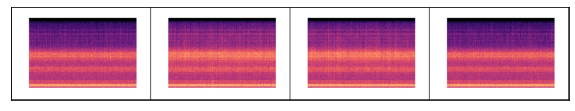

In [16]:
# Просто показать картинки , ничего особенного
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

mobilenet_v3_large best   
** Epoch 53 ** - Epoch Time 130  
Train Loss = 0.1057  
Train Accuracy = 96.42857142857143 %   

Val Loss = 0.1132  
Val Accuracy = 95.83333333333333 %  
  
loss descrease 0.1132363324154756< 0.1356593726155725  

In [5]:
def return_model(num_classes):
    '''
    Эта функция возвращает экземпляр модели, построенной под наше количество классов.
    Мы берем предобученную сеть, например mobilenet_v3_large и меняем ей "голову"
    '''
    model = models.mobilenet_v3_large(pretrained = True)
    
    #print(model)
    
    last_layer_input_features = model.classifier[-1].in_features
    
    model.classifier[-1] = nn.Linear(last_layer_input_features, num_classes, bias = True)
    
    #print(model)
    
    return model

In [18]:
model=return_model(len(classes)) # создаем нашу модель

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Нюансы обучения
#optimizer = torch.optim.Adam(model.classifier.parameters(), lr = 0.0001)
optimizer = torch.optim.Adam(model.classifier.parameters(), lr = 0.0001) # метод оптимизации. ему даем не все параметры 
  # сети а только "голову", которую переделывали. Основное тело, которое выделяет эмбединги(показатели, характеристики, 
  # признаки как удобно) мы не трогаем. оно обучено уже. материал про трансферлернинг
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 4, gamma = 0.5)
criterion = nn.CrossEntropyLoss() # функция потерь

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []


In [20]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

In [21]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

Я сделал обучение с механизмом раннего останова. Чтобы не надо было вбивать количество эпох обучения. Нейронка учится до тех пор, пока уменьшается значение функции потерь. Обучение останавливается само как только значение функции потерь начинает расти (не уменьшается на протяжении max_bad_epoch подряд). В процессе обучения функция потерь уменьшается т.к. мы учимся лучше классифицировать, но в определенный момент она может начать расти, хоть и точность модели все равно растет. Это из-за того что модель стала "заучивать" наши данные и терять обобщающую способность.

In [22]:
%%time
### Training Code
best_model_wts = copy.deepcopy(model.state_dict()) # это чтобы скопировать объект целиком а не указатель
PATH = './best_spectrogram_8_classes_noise.pt' # сохраняем лучший результат. если будете запускать с разными параметрами или 
                                    # на разных данных то меняйте название
best_loss = math.inf
train = True
earley_stoping =8 # ранний останов. количество эпох, идущих подряд без улучшения результата, 
                    # достигнув которое мы останавливаемся но лучше 10
earley_stoping_counter = 0 # счетчик
epoch=0 # счетчик
while train:
    start = time.time()
    
    #Epoch Loss & Accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []
    
    #Val Loss & Accuracy
    val_epoch_loss = []
    val_epoch_accuracy = []
    
    # Training
    for images, labels in train_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Reset Grads
        optimizer.zero_grad()
        
        #Forward ->
        preds = model(images)
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss & Backward, Update Weights (Step) <- backward
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        #Append loss & acc
        loss_value = loss.item()
        train_epoch_loss.append(loss_value)
        train_epoch_accuracy.append(acc)
    
    #Validation
    with torch.no_grad():
        for images, labels in valid_data_loader:

            images = images.to(device)
            labels = labels.to(device)

            #Forward ->
            preds = model(images)

            #Calculate Accuracy
            acc = calc_accuracy(labels.cpu(), preds.cpu())

            #Calculate Loss
            loss = criterion(preds, labels)

            #Append loss & acc
            loss_value = loss.item()
            val_epoch_loss.append(loss_value)
            val_epoch_accuracy.append(acc)

    
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    
    loss_stats['train'].append(train_epoch_loss)
    accuracy_stats['train'].append(train_epoch_accuracy)
    loss_stats['val'].append(val_epoch_loss)
    accuracy_stats['val'].append(val_epoch_accuracy)
    
    end = time.time()
    
    #Print Epoch Statistics
    print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
    print("Train Loss = {}".format(round(train_epoch_loss, 4)))
    print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
    print("Val Loss = {}".format(round(val_epoch_loss, 4)))
    print("Val Accuracy = {} % \n".format(val_epoch_accuracy))
    epoch+=1
    
    # если результат на валидации улучшился то сохраняем текущие веса
    if val_epoch_loss< best_loss:
        print(f'loss descrease {val_epoch_loss}< {best_loss} \n')
        best_loss = val_epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), PATH)
        earley_stoping_counter = 0
    # иначе - обновляем счетчик
    else:
        earley_stoping_counter+=1
        print(f'{earley_stoping_counter} epochs without increasing \n')
    # счетчик неудачных попыток обучения достиг контрольного значения. останавливаемся
    if earley_stoping_counter >= earley_stoping:
        print(f'enough \n')
        train = False
        

** Epoch 0 ** - Epoch Time 501
Train Loss = 0.6944
Train Accuracy = 83.671875 % 

Val Loss = 0.2853
Val Accuracy = 92.8125 % 

loss descrease 0.28531256659771315< inf 

** Epoch 1 ** - Epoch Time 534
Train Loss = 0.1981
Train Accuracy = 95.3125 % 

Val Loss = 0.2104
Val Accuracy = 93.4375 % 

loss descrease 0.21037166988826356< 0.28531256659771315 

** Epoch 2 ** - Epoch Time 513
Train Loss = 0.1415
Train Accuracy = 96.015625 % 

Val Loss = 0.1357
Val Accuracy = 96.40625 % 

loss descrease 0.13567196329677245< 0.21037166988826356 

** Epoch 3 ** - Epoch Time 511
Train Loss = 0.1301
Train Accuracy = 96.2890625 % 

Val Loss = 0.1369
Val Accuracy = 95.78125 % 

1 epochs without increasing 

** Epoch 4 ** - Epoch Time 504
Train Loss = 0.1129
Train Accuracy = 96.5625 % 

Val Loss = 0.0825
Val Accuracy = 97.8125 % 

loss descrease 0.08250578505230806< 0.13567196329677245 

** Epoch 5 ** - Epoch Time 574
Train Loss = 0.094
Train Accuracy = 96.9921875 % 

Val Loss = 0.1408
Val Accuracy = 95.46

only noise

loss descrease 0.29546085921349< 0.29704812765819955 

** Epoch 39 ** - Epoch Time 431
Train Loss = 0.2725
Train Accuracy = 90.0 % 

Val Loss = 0.3421
Val Accuracy = 86.83333333333333 % 

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

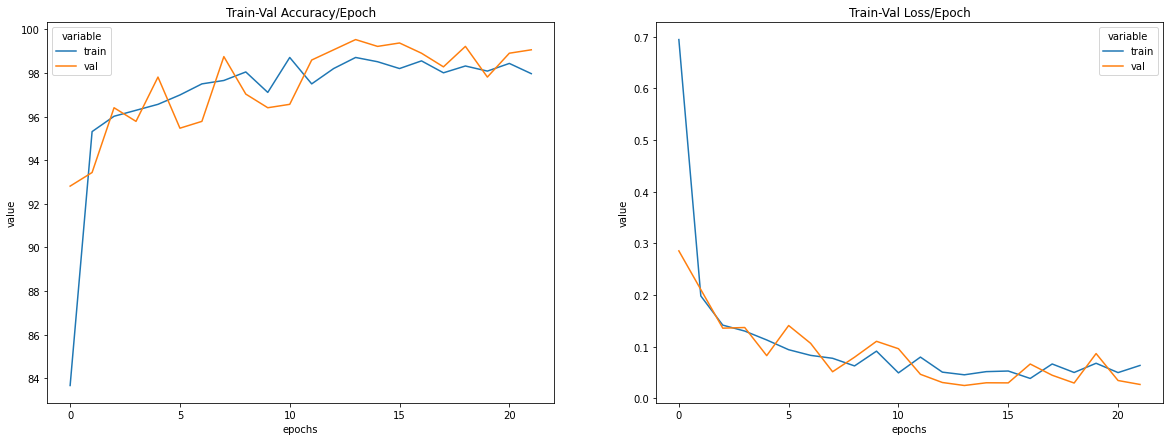

In [23]:
# строим графики как менялась точность и функция потерь в процессе обучения
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=
                                        ['index']).rename(columns={"index":"epochs"})

train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=
                                        ['index']).rename(columns={"index":"epochs"})# Plot the dataframes

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",
             ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable",
             ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [24]:
# Строим графики значений точности и функции потерь в зависимости от количества эпох.
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",
             ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable",
             ax=axes[1]).set_title('Train-Val Loss/Epoch')

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

# Infer

небольшой набросок кода для ручного тестирования

In [6]:
test_transforms = T.Compose([T.ToTensor()])
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()


def infer(model,wav_file,window_size=1024, transforms= None):
    '''
    
    '''
    with torch.no_grad():
        # раздел создания спектрограммы для классификации должен быть полностью 
        # идентичен разделу создания спектрограмм для тренировки. главное параметры n_fft=window_size, hop_length=512
        Audio = AudioSegment.from_wav(wav_file) # считываем аудио
        sample = Audio[0*1000:5*1000]
        sample_name = './temp.wav'
        sample.export(sample_name, format="wav")
        
        
        y, sr = librosa.load(sample_name)
        window = np.hanning(window_size)
        stft  = librosa.core.spectrum.stft(y, n_fft=window_size, hop_length=512, window=window)
        out = 2 * np.abs(stft) / np.sum(window)
        fig = plt.Figure(frameon=False)
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(111)
        ax.axis('off')
        p = librosa.display.specshow(librosa.amplitude_to_db(out, ref=np.max), ax=ax)

        # спктрограмма сохраняется во временный файл
        temp = wav_file.split('/')[-1]
        temp = './' + temp.split('.')[0]+'.png'

        fig.savefig(temp
                    ,pad_inches = 0)


        # считываем так же как в классе Dataset
        image = cv2.imread(temp, cv2.IMREAD_COLOR)
        os.remove(temp)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0


        image_tensor = test_transforms(image).float()
        image_tensor = image_tensor.unsqueeze_(0)
        image_tensor.to(device)

        # осуществляем предсказание
        output = model(image_tensor)
        # Я в качеству выходного слоя использую простой полносвязный слой потому переменная output  
        # выглядит следующим образом tensor([[ 1.1148, -5.1110,  0.7156, -3.0015, -6.2952, -7.0076, -4.0860, -2.2178,
        #     -3.6325, -2.1464,  4.4616,  0.0611]]). Я считаю что такой подход лучше всего 
        # потому что не связывает руки
        index = torch.argmax(output, dim=1)
        # В переменной index лежит индекс самого большого значения в тензоре. для примера выше это будет 10.
        # Если нужно то тензор output можно переделать в тензор с вероятностями командами  
        # sm = torch.nn.Softmax()
        # probabilities = sm(b)
        # тогда тензор с вероятностями для примера выше будет выглядеть следующим образом
        # tensor([[3.2745e-02, 6.4759e-05, 2.1967e-02, 5.3391e-04, 1.9815e-05, 9.7192e-06,
        #     1.8049e-04, 1.1690e-03, 2.8406e-04, 1.2556e-03, 9.3035e-01, 1.1417e-02]],
        # и самая большая вероятность будет опять у элемента с индексом 10
        return index, output

In [7]:
model1=return_model(8) # создаем нашу модель

In [8]:
PATH='./best_spectrogram_8_classes_noise.pt'

In [9]:
model1.load_state_dict(torch.load(PATH))
model1.eval()

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

{'Test11Noise': 0, 'Test13Noise': 1, 'Test1Noise': 2, 'Test3Noise': 3, 'Test4Noise': 4, 'Test5Noise': 5, 'Test6Noise': 6, 'Test7Noise': 7}
{0: 'Test11Noise', 1: 'Test13Noise', 2: 'Test1Noise', 3: 'Test3Noise', 4: 'Test4Noise', 5: 'Test5Noise', 6: 'Test6Noise', 7: 'Test7Noise'}

In [10]:
int_to_class={0: 'Test11Noise', 1: 'Test13Noise', 2: 'Test1Noise', 3: 'Test3Noise', 4: 'Test4Noise', 5: 'Test5Noise', 6: 'Test6Noise', 7: 'Test7Noise'}
int_to_class

{0: 'Test11Noise',
 1: 'Test13Noise',
 2: 'Test1Noise',
 3: 'Test3Noise',
 4: 'Test4Noise',
 5: 'Test5Noise',
 6: 'Test6Noise',
 7: 'Test7Noise'}

In [ ]:
Test1	Исправный, заводское состояние, новый
Test2	Дисбаланс 15 гр
Test3	Дисбаланс 30 гр
Test4	Промыт полностью от смазки. Отсутсивие смазки
Test5	Недостаток смазки
Test6	Грязь в смазке
Test7	Сильно загрязнённая смазка
Test8	Новый подшипник
Test9	Дефект наружнегл кольца, лёгкий
Test10	Дефект наружнегл кольца, средний
Test11	Дефект наружнего кольца, крупный
Test12	Дефект внутреннего кольца, средний
Test13	Дефект внутреннего кольца, крупный

Test1Noise,Test4Noise,Test7Noise,Test11Noise,Test13Noise
Test3Noise>Test1Noise
Test5Noise>Test4Noise
Test6Noise>Test1Noise

In [69]:
index,tensor=infer(model1,'./noise_cut_data/Test13Noise/Test13Noise_69_.wav')   
print(f'пример выходного тензора {tensor}')
print(f'какой индекс получили из тензора {index}')
print(f'сопоставление индекса и имени класса {int_to_class[index.numpy()[0]]}')

пример выходного тензора tensor([[-0.4176,  3.5661, -0.3311,  0.4160, -2.7319, -2.2107, -5.0825,  0.0072]])
какой индекс получили из тензора tensor([1])
сопоставление индекса и имени класса Test13Noise


In [96]:
print(f'пример выходного тензора {tensor}')
print(f'какой индекс получили из тензора {index}')
print(f'сопоставление индекса и имени класса {int_to_class[index.numpy()[0]]}')

пример выходного тензора tensor([[-0.6112, -3.0722,  1.8795, -7.9706, -8.8027, -4.9116, -6.2665, -4.1497,
         -3.3983, -1.0198,  6.4831]])
какой индекс получили из тензора tensor([10])
сопоставление индекса и имени класса Test9


In [194]:
# пример как переделать тензор в вероятности классов
sm = torch.nn.Softmax()
probabilities = sm(tensor)
probabilities

C:\Users\Ysiberia\AppData\Local\Temp\ipykernel_14404\1430241965.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = sm(tensor)


tensor([[4.5064e-08, 5.5071e-06, 7.5314e-09, 5.1724e-07, 1.1304e-08, 1.6622e-07,
         6.9871e-06, 9.0044e-08, 1.0603e-05, 2.6723e-06, 1.5885e-08, 9.9997e-01]])

In [ ]:
Test1	Исправный, заводское состояние, новый
Test2	Дисбаланс 15 гр
Test3	Дисбаланс 30 гр
Test4	Промыт полностью от смазки. Отсутсивие смазки
Test5	Недостаток смазки
Test6	Грязь в смазке
Test7	Сильно загрязнённая смазка
Test8	Новый подшипник
Test9	Дефект наружнегл кольца, лёгкий
Test10	Дефект наружнегл кольца, средний
Test11	Дефект наружнего кольца, крупный
Test12	Дефект внутреннего кольца, средний
Test13	Дефект внутреннего кольца, крупный